# Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

#------------------------------

import matplotlib.pyplot as plt

myparams = {
    'text.usetex': True,
    'text.latex.preamble': '\\usepackage{amsfonts}',
    'text.latex.preamble': '\\usepackage[utf8]{inputenc}',
    'text.latex.preamble': '\\usepackage[russian]{babel}',
    'font.family': 'Djvu Serif',
    'font.size': 14,
    'axes.grid': False,
    'grid.alpha': 0.1,
    'lines.linewidth': 2
}

plt.rcParams.update(myparams)

#------------------------------

%load_ext autoreload
%autoreload 2

# Анализ испытуемых

In [2]:
path = os.path.join(os.path.dirname(os.getcwd()), 'src', 'ds003688-download', 'participants.tsv')
participants = pd.read_csv(path, sep='\t')
participants[participants['fMRI'] == 'yes']

,participant_id,sex,age,handedness,language_dominance,language_dominance_technique,iEEG,fMRI,iEEG_hemisphere,high_density_grid
3,sub-04,M,11,R,possibly L,fMRI,no,yes,NaN,NaN
6,sub-07,F,42,R,L,fMRI,yes,yes,L,no
7,sub-08,M,17,R,L,fTCD + fMRI,no,yes,NaN,NaN
8,sub-09,F,33,R,L,fTCD,yes,yes,L,no
10,sub-11,F,9,NaN,NaN,NaN,no,yes,NaN,NaN
12,sub-13,F,17,L,R,Wada,yes,yes,R,no
13,sub-14,F,18,R,R,Wada,yes,yes,L,yes
14,sub-15,M,14,R,L,fMRI,no,yes,NaN,NaN
15,sub-16,M,17,R,L,Wada,yes,yes,L,no
17,sub-18,F,15,R,L,fMRI,yes,yes,L,no


# Подключение моделей

In [3]:
# видеоряд
from dataloader import FramesLoader
framesloader = FramesLoader()
vector_list = framesloader.get_vector_list()

# снимки фМРТ
from dataloader import Sub

# модели
from models import LinearModel, LinearDeltaModel

# визуализатор
from visualizer import Visualizer

# вспомогательные функции
import utils

# Демонстрация работы метода

In [53]:
sub = Sub('04')
lin = LinearModel(vector_list, sub, 5, 1, 1000)
lin.fit()
lin.predict()
lin.evaluate()

In [54]:
visualizer = Visualizer(lin)

TEST


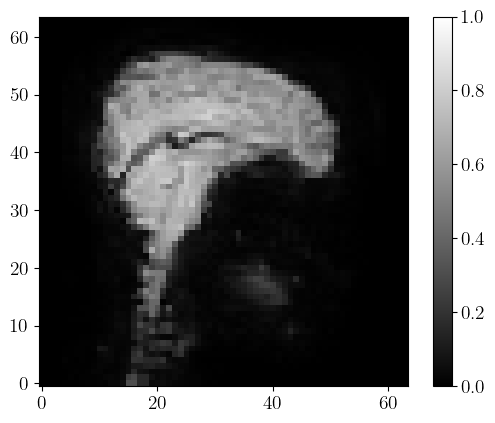

PREDICTED


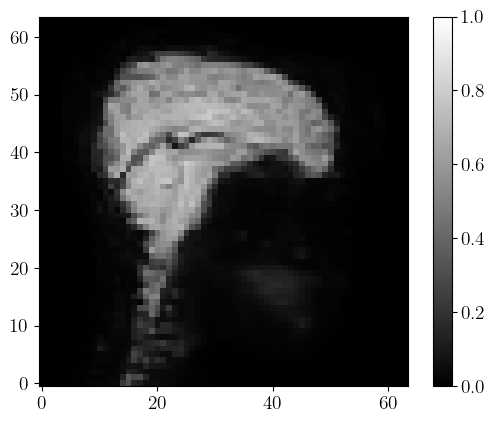

DIFFERENCE


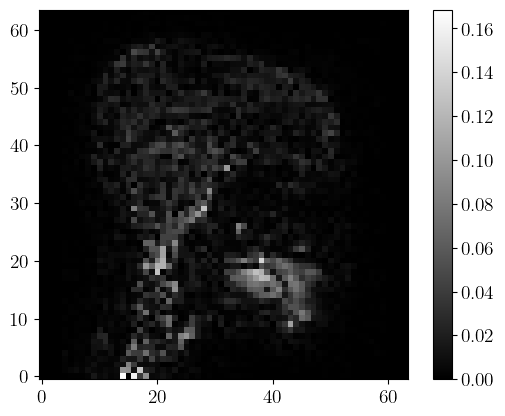

In [55]:
visualizer.show_scan_slices(37, 0, 20)

# Анализ времени задержки

In [ ]:
sub = Sub('47')
lindelta = LinearDeltaModel(vector_list, sub, 5, 1, 1000)
lindelta.fit()
lindelta.predict()
lindelta.evaluate()

In [ ]:
delta_voxels = abs(lindelta.deltaY_train).sum(axis=1)

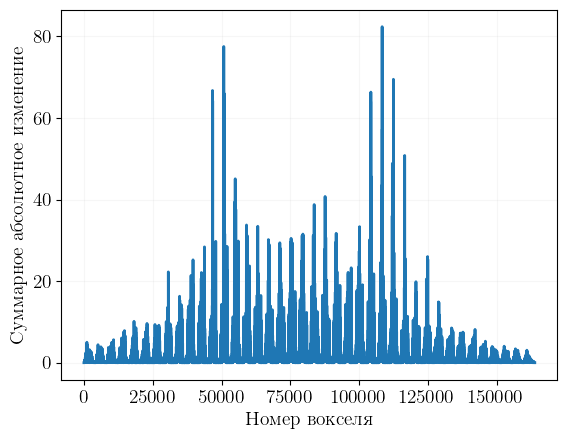

In [ ]:
plt.plot(delta_voxels)
plt.xlabel('Номер вокселя')
plt.ylabel('Суммарное абсолютное изменение')
plt.grid(alpha=0.1)
plt.show()

Можно по-разному выбирать границу отсечения:
- 1/2 максимального значения
- конкретное число, например, 10
- такое число, что, например, ровно 1/4 вокселей будет попадать в область (по сути, 0.75-квантиль)

In [ ]:
d1, d2, d3 = lindelta._d1, lindelta._d2, lindelta._d3
mask1 = np.ones((d1, d2, d3))
mask1.T[:d3//3, :, :] = 0
mask1.T[:, d2//3:, :] = 0
mask1 = mask1.reshape(d1*d2*d3)

In [ ]:
#bound = (delta_voxels * mask1).max() / 2
#bound

In [ ]:
#bound = 7

In [ ]:
array = delta_voxels * mask1
array[array > 0]

array([0.10018163, 0.085496  , 0.09221022, ..., 0.24197266, 0.20875171,
       0.25631957])

In [ ]:
bound = np.quantile(array[array>0], 1 - 1/32)
bound

5.894088893621295

In [ ]:
mask = array > bound
difference = lindelta.Y_test_predicted - np.delete(lindelta.Y_test, 0, 1)
MSE_test_corrected = utils.MSE(difference[np.nonzero(mask)])
d1, d2, d3 = lindelta._d1, lindelta._d2, lindelta._d3
mask = mask.reshape((d1, d2, d3))

In [ ]:
print(f"MSE: {lindelta.MSE_test:.4f}")
print(f"MSE corrected: {MSE_test_corrected:.4f}")

MSE: 0.0001
MSE corrected: 0.0004


Посмотрим, какие воксели получились самыми изменяющимися

In [ ]:
visualizer = Visualizer(lindelta)
mask = mask.reshape((d1, d2, d3))

In [ ]:
print(d1, d2, d3)

40 64 64


TEST


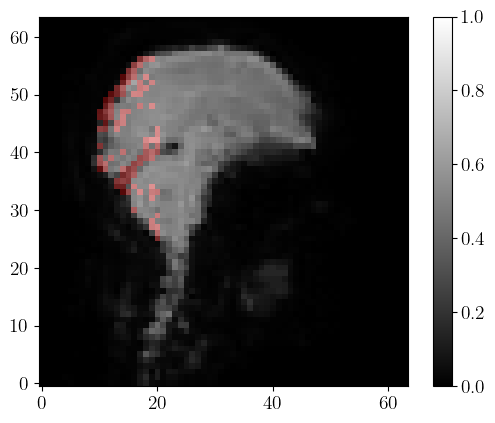

PREDICTED


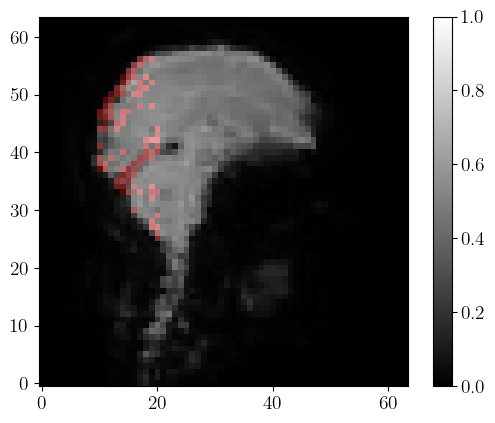

DIFFERENCE


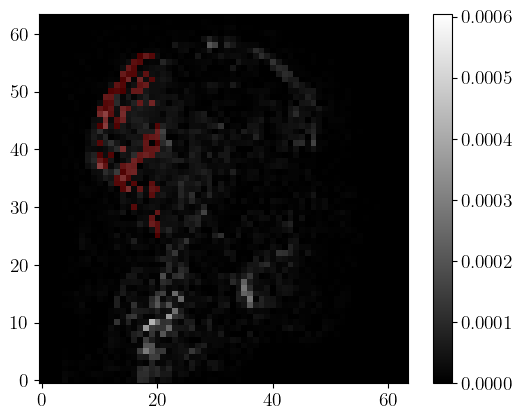

In [ ]:
visualizer.show_scan_slices(37, 0, 20, mask)

Построим график зависимости ошибки от времени задержки только самых изменяющихся вокселях

In [ ]:
# возвращает MSE_test, подсчитанный только на самых изменяющихся вокселях
def evaluate(lindelta: LinearDeltaModel):
    d1, d2, d3 = lindelta._d1, lindelta._d2, lindelta._d3
    mask1 = np.ones((d1, d2, d3))
    mask1.T[:d3//3, :, :] = 0
    mask1.T[:, d2//3:, :] = 0
    mask1 = mask1.reshape(d1*d2*d3)
    delta_voxels = abs(lindelta.deltaY_train).sum(axis=1)
    array = delta_voxels * mask1
    #bound = (delta_voxels * mask1).max() / 2
    #bound = (array[array>0]).max() / 4
    bound = np.quantile(array[array>0], 1 - 1/16)
    mask = array > bound
    difference = lindelta.Y_test_predicted - np.delete(lindelta.Y_test, 0, 1)
    MSE_test = utils.MSE(difference[np.nonzero(mask)])
    return MSE_test

In [ ]:
print(Sub.subs_with_fmri)

['04', '07', '08', '09', '11', '13', '14', '15', '16', '18', '22', '24', '27', '28', '29', '31', '35', '41', '43', '44', '45', '46', '47', '51', '52', '53', '55', '56', '60', '62']


In [ ]:
t = np.linspace(0, 20, 20)

MSE = []
MSE_corrected = []
sub = Sub('47')

for dt in t:
    lindelta = LinearDeltaModel(vector_list, sub, dt, 2, 1000)
    lindelta.fit()
    lindelta.predict()
    lindelta.evaluate()
    MSE.append(lindelta.MSE_test)
    MSE_corrected.append(evaluate(lindelta))

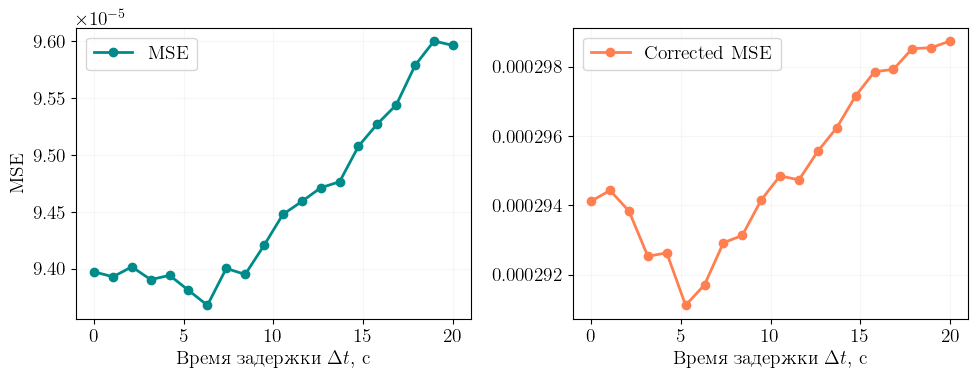

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(t, MSE, marker='o', color="darkcyan", label=r"MSE")
ax[0].set_xlabel("Время задержки $\Delta t$, с")
ax[0].set_ylabel("MSE")
ax[0].legend()
ax[0].grid(alpha=0.1)

ax[1].plot(t, MSE_corrected, marker='o', color="coral", label=r"Corrected MSE")
ax[1].set_xlabel("Время задержки $\Delta t$, с")
#ax[1].set_ylabel("MSE")
ax[1].legend()
ax[1].grid(alpha=0.1)

plt.tight_layout()
plt.savefig("mse_dt.pdf")
plt.show()

In [ ]:
t = np.linspace(0, 10, 20)
MSE_matrix = []
MSE_corrected_matrix = []

for number in Sub.subs_with_fmri:
    MSE = []
    MSE_corrected = []
    sub = Sub(number)
    for dt in t:
        lindelta = LinearDeltaModel(vector_list, sub, dt, 8, 1000)
        lindelta.fit()
        lindelta.predict()
        lindelta.evaluate()
        MSE.append(lindelta.MSE_test)
        MSE_corrected.append(evaluate(lindelta))
    MSE_matrix.append(MSE)
    MSE_corrected_matrix.append(MSE_corrected)

MSE_matrix = np.array(MSE_matrix)
MSE_corrected_matrix = np.array(MSE_corrected_matrix)

In [ ]:
MSE_means = MSE_matrix.mean(axis=0)
MSE_stds = MSE_matrix.std(axis=0)

In [ ]:
MSE_corrected_means = MSE_corrected_matrix.mean(axis=0)
MSE_corrected_stds = MSE_corrected_matrix.std(axis=0)

# Подбор оптимального коэффициента регуляризации

In [130]:
alphas = np.logspace(-3, 8, 12)
MSE_matrix_alpha_8 = []
MSE_matrix_alpha_4 = []
MSE_matrix_alpha_2 = []
MSE_matrix_alpha_1 = []

for number in Sub.subs_with_fmri[:3]:

    MSE_8 = []
    MSE_4 = []
    MSE_2 = []
    MSE_1 = []
    sub = Sub(number)

    for alpha in alphas:

        lindelta = LinearDeltaModel(vector_list, sub, 5, 8, alpha)
        lindelta.fit()
        lindelta.predict()
        lindelta.evaluate()
        MSE_8.append(lindelta.MSE_test)

        lindelta = LinearDeltaModel(vector_list, sub, 5, 4, alpha)
        lindelta.fit()
        lindelta.predict()
        lindelta.evaluate()
        MSE_4.append(lindelta.MSE_test)

        lindelta = LinearDeltaModel(vector_list, sub, 5, 2, alpha)
        lindelta.fit()
        lindelta.predict()
        lindelta.evaluate()
        MSE_2.append(lindelta.MSE_test)

        lindelta = LinearDeltaModel(vector_list, sub, 5, 1, alpha)
        lindelta.fit()
        lindelta.predict()
        lindelta.evaluate()
        MSE_1.append(lindelta.MSE_test)

    MSE_matrix_alpha_8.append(MSE_8)
    MSE_matrix_alpha_4.append(MSE_4)
    MSE_matrix_alpha_2.append(MSE_2)
    MSE_matrix_alpha_1.append(MSE_1)

MSE_matrix_alpha_8 = np.array(MSE_matrix_alpha_8)
MSE_matrix_alpha_4 = np.array(MSE_matrix_alpha_4)
MSE_matrix_alpha_2 = np.array(MSE_matrix_alpha_2)
MSE_matrix_alpha_1 = np.array(MSE_matrix_alpha_1)

In [132]:
path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "src", "MSE_alpha.npy")
array = np.array([MSE_matrix_alpha_8, MSE_matrix_alpha_4, MSE_matrix_alpha_2, MSE_matrix_alpha_1], dtype=object)
np.save(path, array, allow_pickle=True)

In [40]:
path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "src", "MSE_alpha.npy")
MSE_matrix_alpha_8, MSE_matrix_alpha_4, MSE_matrix_alpha_2, MSE_matrix_alpha_1 = np.load(path, allow_pickle=True)

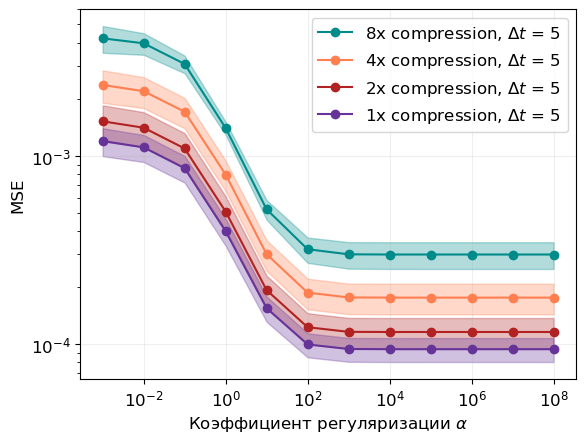

In [43]:
MSE_means_alpha_8 = np.array([vector.mean() for vector in MSE_matrix_alpha_8.T])
MSE_stds_alpha_8 = np.array([vector.std() for vector in MSE_matrix_alpha_8.T])

MSE_means_alpha_4 = np.array([vector.mean() for vector in MSE_matrix_alpha_4.T])
MSE_stds_alpha_4 = np.array([vector.std() for vector in MSE_matrix_alpha_4.T])

MSE_means_alpha_2 = np.array([vector.mean() for vector in MSE_matrix_alpha_2.T])
MSE_stds_alpha_2 = np.array([vector.std() for vector in MSE_matrix_alpha_2.T])

MSE_means_alpha_1 = np.array([vector.mean() for vector in MSE_matrix_alpha_1.T])
MSE_stds_alpha_1 = np.array([vector.std() for vector in MSE_matrix_alpha_1.T])

plt.rcParams.update({'font.size': 12})
plt.rc("font", family='sans-serif')

plt.plot(alphas, MSE_means_alpha_8, marker='o', color="darkcyan", label=r"8x compression, $\Delta t$ = 5")
plt.fill_between(alphas, MSE_means_alpha_8 - MSE_stds_alpha_8, MSE_means_alpha_8 + MSE_stds_alpha_8, color="darkcyan", alpha = 0.3)
plt.plot(alphas, MSE_means_alpha_4, marker='o', color="coral", label=r"4x compression, $\Delta t$ = 5")
plt.fill_between(alphas, MSE_means_alpha_4 - MSE_stds_alpha_4, MSE_means_alpha_4 + MSE_stds_alpha_4, color="coral", alpha = 0.3)
plt.plot(alphas, MSE_means_alpha_2, marker='o', color="firebrick", label=r"2x compression, $\Delta t$ = 5")
plt.fill_between(alphas, MSE_means_alpha_2 - MSE_stds_alpha_2, MSE_means_alpha_2 + MSE_stds_alpha_2, color="firebrick", alpha = 0.3)
plt.plot(alphas, MSE_means_alpha_1, marker='o', color="rebeccapurple", label=r"1x compression, $\Delta t$ = 5")
plt.fill_between(alphas, MSE_means_alpha_1 - MSE_stds_alpha_1, MSE_means_alpha_1 + MSE_stds_alpha_1, color="rebeccapurple", alpha = 0.3)
plt.xlabel("Коэффициент регуляризации $\\alpha$")
plt.ylabel("MSE")
#plt.ylim(0.7 * abs(mse_means - mse_stds).max(), 1.1 * abs(mse_means + mse_stds).max())
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(alpha=0.2)

plt.savefig(os.path.join(figures, "subs_MSE_alpha.pdf"), bbox_inches="tight")

# Анализ распределения весов модели

In [114]:
sub = Sub('04')

In [115]:
lindelta = LinearDeltaModel(vector_list, sub, 5, 1, 1000)
lindelta.fit()

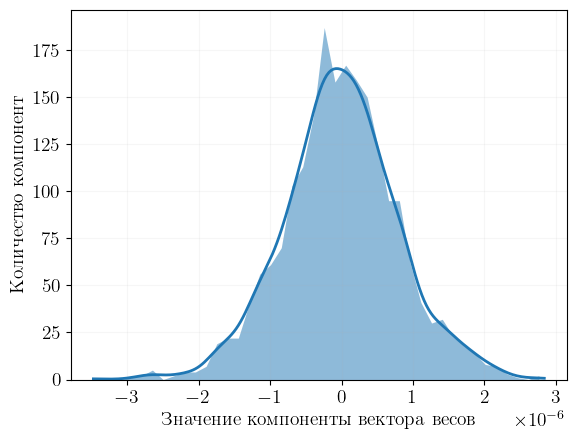

In [117]:
visualizer = Visualizer(lindelta)
visualizer.show_mean_weight_distribution()
plt.savefig("distribution.pdf", bbox_inches="tight")

---

Попробуем проверить нормальность распределения с помощью критерия Шапиро-Уилка

In [62]:
from scipy.stats import shapiro
w_mean = np.mean(lindelta.W, axis=0)
pvalue = shapiro(w_mean)[1]

Достигаемый уровень значимости для нулевой гипотезы "Распределение является нормальным"

In [63]:
print(f'pvalue = {pvalue:.2e}')

pvalue = 1.44e-05


Достигаемый уровень значимости позволяет отвергнуть нулевую гипотезу, т.е. распределение нормалньным не является. Тем не менее, оно не равномерное, поэтому построенная модель прогнозирования согласуется с восприятием видеоряда человеком.

# Гипотеза инвариантности весов модели относительно человека

In [ ]:
sub4 = Sub('04')
sub7 = Sub('07')

In [ ]:
lindelta4 = LinearDeltaModel(vector_list, sub4, 5, 1, 1000)
lindelta7 = LinearDeltaModel(vector_list, sub7, 5, 1, 1000)
mix = LinearDeltaModel(vector_list, sub7, 5, 1, 1000)

In [ ]:
lindelta4.fit()
lindelta4.predict()
lindelta4.evaluate()

lindelta7.fit()
lindelta7.predict()
lindelta7.evaluate()

mix.fit()
mix.predict()
mix.evaluate()

In [ ]:
Y_test_predicted = mix.repredict(lindelta4.W)
MSE_test = mix.evaluate(Y_test_predicted)
MSE_test

9.749764815004539e-05

In [ ]:
print(f"Original MSE_test: {lindelta7.MSE_test}")
print(f"Mixed MSE_test: {MSE_test}")
print(f"Difference: {abs(MSE_test - lindelta7.MSE_test)}")

Original MSE_test: 9.749368716477118e-05
Mixed MSE_test: 9.749764815004539e-05
Difference: 3.96098527420544e-09


In [ ]:
for num in Sub.subs_with_fmri:
    lindelta = LinearDeltaModel(Sub(num), 5, 1, 1000)
    lindelta.fit()
    lindelta.predict()
    lindelta.evaluate()
    utils.save_object(lindelta.W, f"lindelta-W-{num}.pkl")

In [ ]:
# i строка - берется i-ый испытуемый и к нему подмешиваются остальные (используются их матрицы весов)
# j столбец - берется j-ый испытуемый и подмешивается к остальным (используется его матрица весов)
errors = np.zeros((len(Sub.subs_with_fmri), len(Sub.subs_with_fmri)))

In [ ]:
counter = 0
print(f"The process of filling in the error matrix has started [{counter}/{errors.shape[0] * errors.shape[1]}]\n")

for i in range(errors.shape[0]):
    lindelta = LinearDeltaModel(Sub(Sub.subs_with_fmri[i]), 5, 1, 1000)
    lindelta.fit()
    lindelta.predict()
    lindelta.evaluate()
    for j in range(errors.shape[1]):
        if i == j:
            errors[i][j] = lindelta.MSE_test
        else:
            W = utils.load_object(f"lindeltapred-W-{sub.subs_with_fmri[j]}.pkl")
            errors[i][j] = lindelta.repredict(W)
        counter += 1
        print(f"[{counter}/{errors.shape[0] * errors.shape[1]}]: errors[{i}][{j}] = {errors[i][j]}")

The process of filling in the error matrix has started [0/900]

[1/900]: errors[0][0] = 0.00010887398565506218
[2/900]: errors[0][1] = 0.00010900381651686263
[3/900]: errors[0][2] = 0.00010896205656009976
[4/900]: errors[0][3] = 0.00010901835849875455
[5/900]: errors[0][4] = 0.00010894890100517538
[6/900]: errors[0][5] = 0.00010884914759461071
[7/900]: errors[0][6] = 0.00010928295128708832
[8/900]: errors[0][7] = 0.00010923043515144097
[9/900]: errors[0][8] = 0.00010944451477955181
[10/900]: errors[0][9] = 0.0001088782992252496
[11/900]: errors[0][10] = 0.00010879594172283322
[12/900]: errors[0][11] = 0.00010923751300813255
[13/900]: errors[0][12] = 0.00010896583535174628
[14/900]: errors[0][13] = 0.00010914541056324956
[15/900]: errors[0][14] = 0.00010895207686188552
[16/900]: errors[0][15] = 0.00010923700256943652
[17/900]: errors[0][16] = 0.00010912205813469299
[18/900]: errors[0][17] = 0.00010924940076113565
[19/900]: errors[0][18] = 0.00010929122949549549
[20/900]: errors[0][19] =

In [ ]:
utils.save_object(errors, "errors.pkl")

In [ ]:
errors = utils.load_object("errors.pkl")

In [ ]:
# содержит отличие MSE от диагонального элемента в процентах
errors_scaled = ((errors.T / np.array([errors[i][i] for i in range(errors.shape[0])])).T - np.ones((errors.shape[0], errors.shape[0]))) * 100

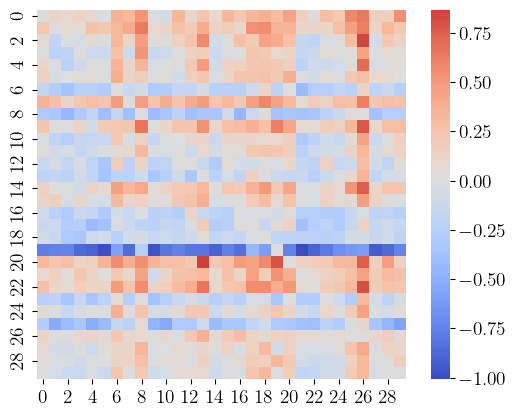

In [ ]:
sns.heatmap(errors_scaled, square=True, center=0, cmap="coolwarm")
plt.savefig("heatmap.pdf", bbox_inches='tight')
plt.show()

# Корректность работы метода

In [64]:
sub35 = Sub('35')

In [65]:
lindelta35 = LinearDeltaModel(vector_list, sub35, 5, 1, 1000)
noised = LinearDeltaModel(vector_list, sub35, 5, 1, 1000)

In [66]:
lindelta35.fit()
lindelta35.predict()
lindelta35.evaluate()

In [67]:
X_random_train = np.random.rand(lindelta35.X_train.shape[0], lindelta35.X_train.shape[1])
X_random_test = np.random.rand(lindelta35.X_test.shape[0], lindelta35.X_test.shape[1])
#X_random_train = np.ones((lindelta35.X_train.shape[0], lindelta35.X_train.shape[1]))
#X_random_test = np.ones((lindelta35.X_test.shape[0], lindelta35.X_test.shape[1]))

In [68]:
noised.deltaY_train_predicted = lindelta35.W @ X_random_train.T
noised.deltaY_test_predicted = lindelta35.W @ X_random_test.T
noised.Y_train_predicted = np.delete(noised.Y_train, -1, 1) + noised.deltaY_train_predicted
noised.Y_test_predicted = np.delete(noised.Y_test, -1, 1) + noised.deltaY_test_predicted
    
noised.MSE_test = noised.evaluate(noised.Y_test_predicted)

In [69]:
lindelta35.MSE_test

0.00015457523719500707

In [70]:
noised.MSE_test

0.0001545439049138533

In [71]:
visualizer35 = Visualizer(lindelta35)
visualizernoised = Visualizer(noised)

TEST


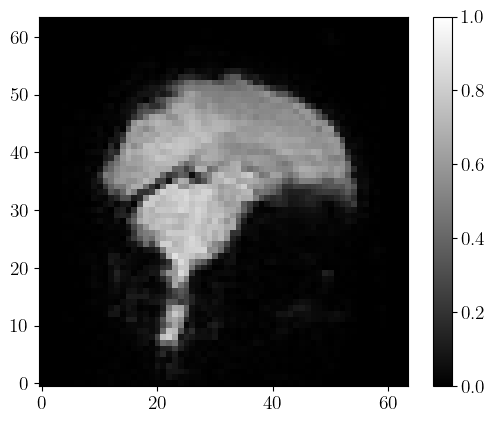

PREDICTED


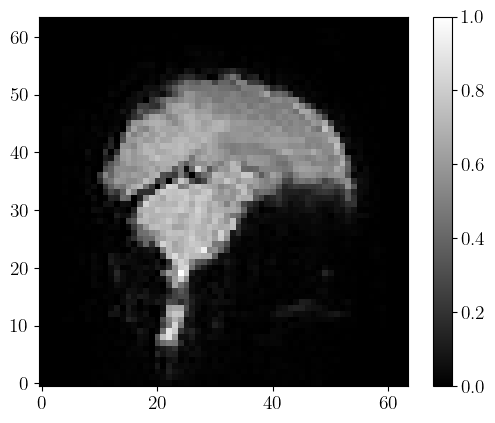

DELTA


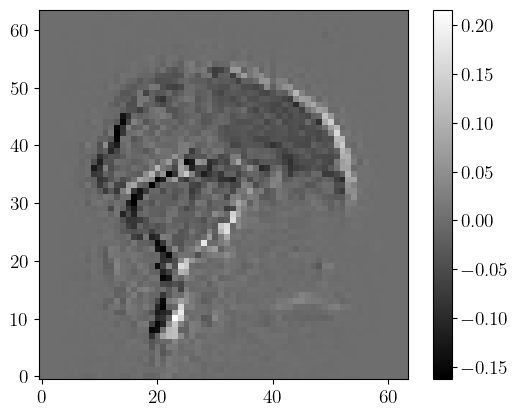

DIFFERENCE


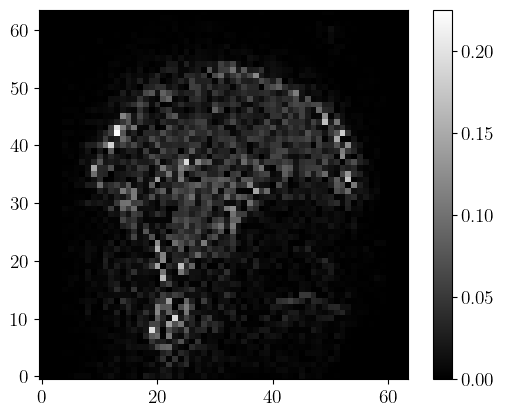

In [72]:
visualizer35.show_recovered_scan_slices(-1, 0, 20)

In [74]:
scan_test = lindelta35.Y_test.T[-1]
scan_predicted = lindelta35.Y_test.T[0] + np.sum(lindelta35.deltaY_test_predicted.T[:-1], axis = 0)

In [75]:
MSE_test = np.linalg.norm(scan_test - scan_predicted) ** 2 / scan_test.shape[0]
MSE_test

0.0004874186244186696

TEST


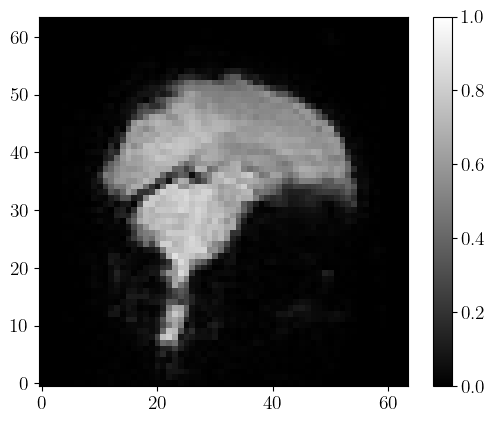

PREDICTED


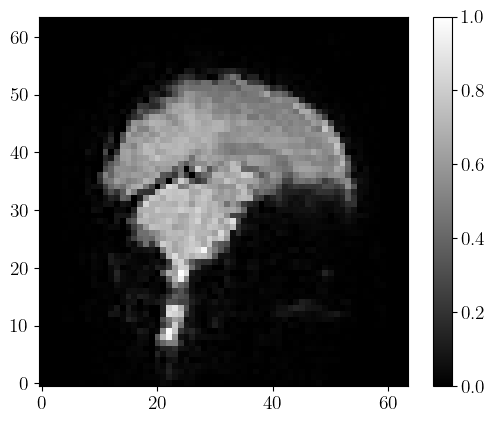

DELTA


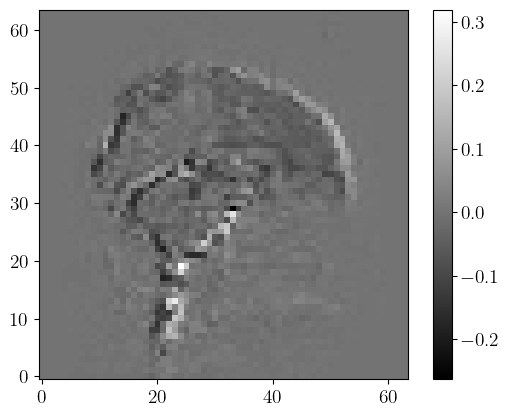

DIFFERENCE


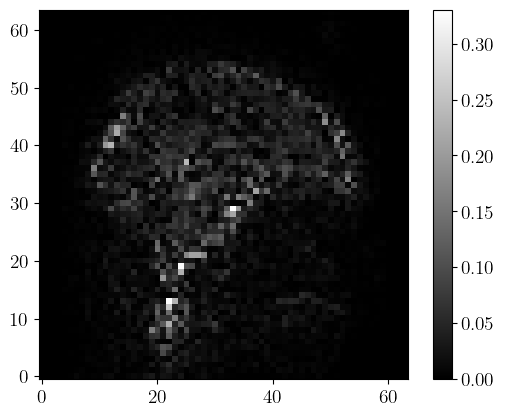

In [73]:
visualizernoised.show_recovered_scan_slices(-1, 0, 20)

In [76]:
scan_test = noised.Y_test.T[-1]
scan_predicted = noised.Y_test.T[0] + np.sum(noised.deltaY_test_predicted.T[:-1], axis = 0)

In [77]:
MSE_test = np.linalg.norm(scan_test - scan_predicted) ** 2 / scan_test.shape[0]
MSE_test

0.0006052453002876153